In [ ]:
pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 33.8 MB/s eta 0:00:00


In [ ]:
#@title
!pip uninstall torch -y
!pip uninstall torchvision -y
!pip uninstall torchtext -y
!pip uninstall torchaudio -y
!pip uninstall torchdata -y
!pip install torchvision==0.14.0
!pip install torch==1.13.0

Found existing installation: torch 2.0.0+cu118
Uninstalling torch-2.0.0+cu118:
  Successfully uninstalled torch-2.0.0+cu118
Found existing installation: torchvision 0.15.1+cu118
Uninstalling torchvision-0.15.1+cu118:
  Successfully uninstalled torchvision-0.15.1+cu118
Found existing installation: torchtext 0.15.1
Uninstalling torchtext-0.15.1:
  Successfully uninstalled torchtext-0.15.1
Found existing installation: torchaudio 2.0.1+cu118
Uninstalling torchaudio-2.0.1+cu118:
  Successfully uninstalled torchaudio-2.0.1+cu118
Found existing installation: torchdata 0.6.0
Uninstalling torchdata-0.6.0:
  Successfully uninstalled torchdata-0.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 62.3 MB/s eta 0:00:00
     ━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
version_str="py39_cu116_pyt1131"
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py39_cu116_pyt1131/download.html


## **Some necessary folders to be created as given below:**

1.   Output_dir
2.   Output_img
3.   Output_mesh
4.   Output_obj
5.   Load the "canonical_face_model.obj"



# **Downloading the PRE TRAINED MODEL**

In [ ]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK
!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2
datFile =  "/content/shape_predictor_68_face_landmarks.dat"

--2023-04-08 11:24:13--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  51.8MB/s    in 1.2s    

2023-04-08 11:24:14 (51.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



# **Importing all the required libraries**

In [ ]:
import sys
import os
import dlib
import glob
import numpy as np
from skimage import io
import cv2
from imutils import face_utils
from google.colab.patches import cv2_imshow

# **Functions for resizing, developing facial landmarks, transformations and building morph sequence** 

In [ ]:
## FINDING THE DIFFERENCES AND AVERAGES BETWEEN THE 2 IMAGES
def calculate_margin_help(img1,img2):

  ## RETURNS THE NUMBER OF ROWS AND COLUMNS
    size1, size2 = img1.shape, img2.shape

  ## FINDING THE HALF OF ABSOLUTE DIFFERENCE FOR PADDING AND CROPPING
    diff0 = abs(size1[0] - size2[0]) // 2
    diff1 = abs(size1[1] - size2[1]) // 2
    avg0, avg1 = (size1[0] + size2[0]) // 2, (size1[1] + size2[1]) // 2
    return size1, size2, diff0, diff1, avg0, avg1

In [ ]:
## IMAGE RESIZING AND CROPPING IF NEEDED AND RETURN THEM AS A LIST
def crop_image(img1, img2):
    size1 = img1.shape
    size2 = img2.shape
    diff0 = abs(size1[0] - size2[0]) // 2
    diff1 = abs(size1[1] - size2[1]) // 2
    avg0 = (size1[0] + size2[0]) // 2
    avg1 = (size1[1] + size2[1]) // 2

    ## CHECKS IF FIRST TWO ELEMENTS OF BOTH ARE EQUAL, IF SO, IT RETURNS THE 2 INPUT IMAGES IN A LIST
    if size1[0] == size2[0] and size1[1] == size2[1]:
        return [img1, img2]

    ## RESIZES THE LARGER OF 2 IMAGES TO MATCH THE DIMENSIONS
    elif size1[0] <= size2[0] and size1[1] <= size2[1]:
        scale0 = size1[0] / size2[0]
        scale1 = size1[1] / size2[1]
        res = cv2.resize(img2, None, fx=max(scale0, scale1), fy=max(scale0, scale1), interpolation=cv2.INTER_AREA)
        return crop_image_help(img1, res)

    elif size1[0] >= size2[0] and size1[1] >= size2[1]:
        scale0 = size2[0] / size1[0]
        scale1 = size2[1] / size1[1]
        res = cv2.resize(img1, None, fx=max(scale0, scale1), fy=max(scale0, scale1), interpolation=cv2.INTER_AREA)
        return crop_image_help(res, img2)

    ## CROPS THE 2 IMAGES ALONG THEIR FIRST DIMENSION AND RETURNS LIST CONTAINING CROPPED VERSION
    elif size1[0] >= size2[0] and size1[1] <= size2[1]:
        return [img1[diff0:avg0, :], img2[:, -diff1:avg1]]

    else:
        return [img1[:, diff1:avg1], img2[-diff0:avg0, :]]

In [ ]:
## CROPS 2 IMAGES BASED ON THEIR SIZE AND RETURNS THEM AS A LIST OF IMAGES
def crop_image_help(img1, img2):
    size1, size2, diff0, diff1, avg0, avg1 = calculate_margin_help(img1, img2)
    if size1 == size2:
        return [img1, img2]
    if size1[0] <= size2[0] and size1[1] <= size2[1]:
        return [img1, img2[-diff0:avg0, -diff1:avg1]]
    if size1[0] >= size2[0] and size1[1] >= size2[1]:
        return [img1[diff0:avg0, diff1:avg1], img2]
    if size1[0] >= size2[0] and size1[1] <= size2[1]:
        return [img1[diff0:avg0, :], img2[:, -diff1:avg1]]
    return [img1[:, diff1:avg1], img2[diff0:avg0, :]]

In [ ]:
## IT GENERATES CORRESPONDING FACIAL LANDMARKS BETWEEN 2 INPUT IMAGES USING A PRE TRAINED MODEL

def generate_face_correspondences(theImage1, theImage2):
    # Initialize face detector and predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(datFile)

    # Initialize arrays to store the corresponding facial landmarks
    list1 = []
    list2 = []

    # Crop the two input images and iterate over them
    imgList = crop_image(theImage1, theImage2)
    for j, img in enumerate(imgList, start=1):
        size = (img.shape[0], img.shape[1])
        currList = list1 if j == 1 else list2

        # Use the face detector to detect faces in the image
        dets = detector(img, 1)

        class NoFaceFound(Exception):
          pass

        # If no faces are detected, raise an exception
        if len(dets) == 0:
            raise NoFaceFound("Sorry, but I couldn't find a face in the image.")

        # Iterate over each detected face and extract its facial landmarks
        for rect in dets:
            shape = predictor(img, rect)
            for i in range(0, 68):
                x = shape.part(i).x
                y = shape.part(i).y
                currList.append((x, y))

        # Add background landmarks to the list
        currList.extend([(1, 1), (size[1]-1, 1), ((size[1]-1)//2, 1),
                         (1, size[0]-1), (1, (size[0]-1)//2),
                         ((size[1]-1)//2, size[0]-1), (size[1]-1, size[0]-1),
                         ((size[1]-1), (size[0]-1)//2)])

    # Compute the average of the corresponding landmarks
    corresp = np.zeros((68, 2))
    for i in range(68):
        corresp[i][0] = (list1[i][0] + list2[i][0]) / 2
        corresp[i][1] = (list1[i][1] + list2[i][1]) / 2

    # Add background landmarks to the array
    narray = np.append(corresp, [[1, 1]], axis=0)
    narray = np.append(narray, [[size[1]-1, 1]], axis=0)
    narray = np.append(narray, [[(size[1]-1)//2, 1]], axis=0)
    narray = np.append(narray, [[1, size[0]-1]], axis=0)
    narray = np.append(narray, [[1, (size[0]-1)//2]], axis=0)
    narray = np.append(narray, [[(size[1]-1)//2, size[0]-1]], axis=0)
    narray = np.append(narray, [[size[1]-1, size[0]-1]], axis=0)
    narray = np.append(narray, [[(size[1]-1), (size[0]-1)//2]], axis=0)

    # Return the output as a list
    return [size, imgList[0], imgList[1], list1, list2, narray]

In [ ]:
# Check if a point is inside a rectangle
def is_point_inside_rect(rect, point):
    x, y = point
    x1, y1, x2, y2 = rect
    return x1 <= x <= x2 and y1 <= y <= y2

# Write the delaunay triangles into a list
def get_delaunay_triangles(img_width, img_height, subdiv, point_dict):
    triangle_list = []
    triangle_points = subdiv.getTriangleList()
    rect = (0, 0, img_width, img_height)
    for points in triangle_points:
        pt1 = (int(points[0]), int(points[1]))
        pt2 = (int(points[2]), int(points[3]))
        pt3 = (int(points[4]), int(points[5]))
        if is_point_inside_rect(rect, pt1) and is_point_inside_rect(rect, pt2) and is_point_inside_rect(rect, pt3):
            triangle_list.append((point_dict[pt1], point_dict[pt2], point_dict[pt3]))
    return triangle_list

def make_delaunay_triangles(img_width, img_height, point_list, img1, img2):
    rect = (0, 0, img_width, img_height)
    subdiv = cv2.Subdiv2D(rect)
    points = [(int(x[0]), int(x[1])) for x in point_list]
    point_dict = {x[0]: x[1] for x in zip(points, range(76))}
    for p in points:
        subdiv.insert(p)
    return get_delaunay_triangles(img_width, img_height, subdiv, point_dict)

In [ ]:
def apply_affine_transform(src, srcTri, dstTri, size):
    warpMat = cv2.getAffineTransform(srcTri, dstTri)
    dst = cv2.warpAffine(src, warpMat, size)

    return dst

In [ ]:
# Applies an affine transform to a source image and outputs the transformed image.
def apply_affine_transform(src, src_tri, dst_tri, size):
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))
    dst = cv2.warpAffine(src, warp_mat, (size[0], size[1]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return dst

# Warps and blends triangular regions from two images to a third image.
def morph_triangle(img1, img2, img, t1, t2, t, alpha):
    # Find bounding rectangle for each triangle.
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))

    # Offset points by left top corner of the respective rectangles.
    t_rect = [((t[i][0] - r[0]), (t[i][1] - r[1])) for i in range(0, 3)]
    t1_rect = [((t1[i][0] - r1[0]), (t1[i][1] - r1[1])) for i in range(0, 3)]
    t2_rect = [((t2[i][0] - r2[0]), (t2[i][1] - r2[1])) for i in range(0, 3)]

    # Get mask by filling triangle.
    mask = np.zeros((r[3], r[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(t_rect), (1.0, 1.0, 1.0), 16, 0)

    # Apply warpImage to small rectangular patches.
    img1_rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2_rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warp_img1 = apply_affine_transform(img1_rect, t1_rect, t_rect, size)
    warp_img2 = apply_affine_transform(img2_rect, t2_rect, t_rect, size)

    # Alpha blend rectangular patches.
    img_rect = (1.0 - alpha) * warp_img1 + alpha * warp_img2

    # Copy triangular region of the rectangular patch to the output image.
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask) + img_rect * mask

In [ ]:
# A function that generates a sequence of morphed images
# by interpolating between two input images

def generate_morph_sequence(img1, img2, points1, points2, tri_list, num_images):
    morphed_frames = []
    for j in range(0, num_images):
        # Convert Mat to float data type
        img1 = np.float32(img1)
        img2 = np.float32(img2)

        # Read array of corresponding points
        points = []
        alpha = j / (num_images - 1)

        # Compute weighted average point coordinates
        for i in range(0, len(points1)):
            x = (1 - alpha) * points1[i][0] + alpha * points2[i][0]
            y = (1 - alpha) * points1[i][1] + alpha * points2[i][1]
            points.append((x, y))

        # Allocate space for final output
        morphed_frame = np.zeros(img1.shape, dtype=img1.dtype)

        for i in range(len(tri_list)):
            x = int(tri_list[i][0])
            y = int(tri_list[i][1])
            z = int(tri_list[i][2])

            t1 = [points1[x], points1[y], points1[z]]
            t2 = [points2[x], points2[y], points2[z]]
            t = [points[x], points[y], points[z]]

            # Morph one triangle at a time.
            morph_triangle(img1, img2, morphed_frame, t1, t2, t, alpha)\

        #Appending the frames to list
        morphed_frames.append(morphed_frame)

        cv2_imshow(morphed_frame)

    return morphed_frames

# **Calling the function to get the morphed display**

In [ ]:
def doMorphing(img1, img2, no_frames, output):
  [size, img1, img2, points1, points2, list3] = generate_face_correspondences(img1, img2)
  tri = make_delaunay_triangles(size[1], size[0], list3, img1, img2)
  morphed_frames = generate_morph_sequence(img1, img2, points1, points2, tri, no_frames)

  #Saving each frame
  for i, frame in enumerate(morphed_frames):
    filename = f"/content/Output_dir/frame_{i}.jpg"
    cv2.imwrite(filename, frame)

image1 = cv2.imread("/content/img21.jpg")
image2 = cv2.imread("/content/img2.jpg")

doMorphing(image1, image2, 3, "/Output_dir")

NameError: ignored

# **Demo code for getting a face mesh**

In [ ]:
import mediapipe as mp

#CREATING A OBJECT TO ACCESS MESH
mp_holistic = mp.solutions.holistic

#CREATING OBJECT TO DRAW THE FACE MESH ON IMAGE
mp_drawing = mp.solutions.drawing_utils

#READING THE INTERMEDIATE FRAME
image = cv2.imread('/content/Output_dir/frame_1.jpg')

#CONVERTING IMAGE TO RGB FORMAT
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#DETECTING FACE MESH ON IMAGE
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    results = holistic.process(image_rgb)

#DRAWING FACE MESH ON THE IMAGE
image_with_mesh = image.copy()
mp_drawing.draw_landmarks(image_with_mesh, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)

#SAVING THE IMAGE
cv2.imwrite('/content/Output_img/facemesh.jpg', image_with_mesh)
cv2_imshow(image_with_mesh)

# **Code for getting face mesh in a seperate background**

In [ ]:
import cv2
import mediapipe as mp

# Creating a holistic object to access the mesh
mp_holistic = mp.solutions.holistic
 
# Creating an object to draw the face mesh on the image
mp_drawing = mp.solutions.drawing_utils

# Reading the intermediate frame
image = cv2.imread('/content/Output_dir/frame_1.jpg')

# Converting the image to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detecting the face mesh on the image
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    results = holistic.process(image_rgb)

# Creating an empty numpy array for the mask
mask = np.zeros_like(image)

# Drawing the face mesh on the mask
mp_drawing.draw_landmarks(mask, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1), connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1))


# Creating a new numpy array for the output image
output_image = np.zeros_like(image)

# Applying the mask to the output image
output_image[mask != 0] = image[mask != 0]

# Saving the output image
cv2.imwrite('/content/Output_img/facemesh.jpg', output_image)
cv2_imshow(output_image)


# **Same as above, but done in a loop as in our case**

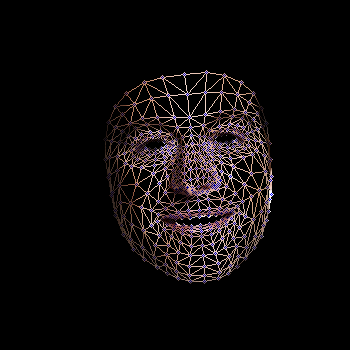

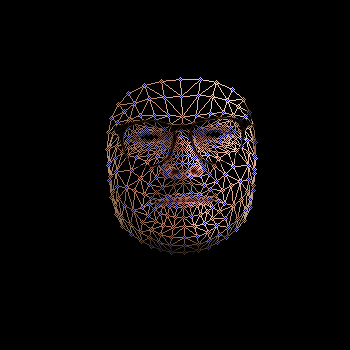

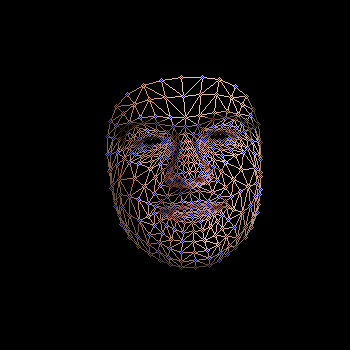

In [ ]:
import cv2
import mediapipe as mp
import os

# Creating a holistic object to access the mesh
mp_holistic = mp.solutions.holistic

# Creating an object to draw the face mesh on the image
mp_drawing = mp.solutions.drawing_utils

# Directory of input and output images
input_dir = "/content/Output_dir/"
output_dir = "/content/Output_mesh/"

# Looping through each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg') and "frame_" in filename:
        # Reading the input frame
        image = cv2.imread(os.path.join(input_dir, filename))

        # Converting the image to RGB format
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detecting the face mesh on the image
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            results = holistic.process(image_rgb)

        # Creating an empty numpy array for the mask
        mask = np.zeros_like(image)

        # Drawing the face mesh on the mask
        mp_drawing.draw_landmarks(mask, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1), connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1))

        # Creating a new numpy array for the output image
        output_image = np.zeros_like(image)

        # Applying the mask to the output image
        output_image[mask != 0] = image[mask != 0]

        # Saving the output image in the output directory with the same filename
        cv2.imwrite(os.path.join(output_dir, filename), output_image)
        cv2_imshow(output_image)


# **Displaying the original image and the face mesh correspondingly**

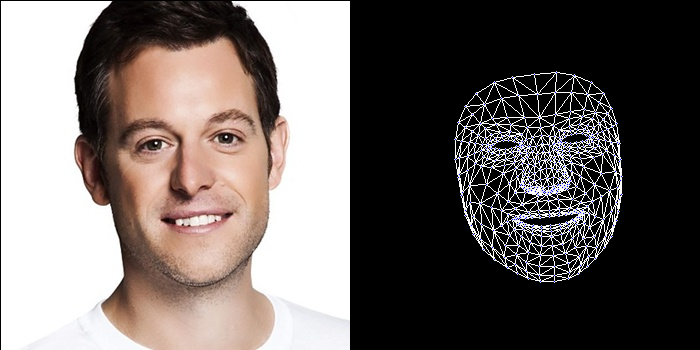

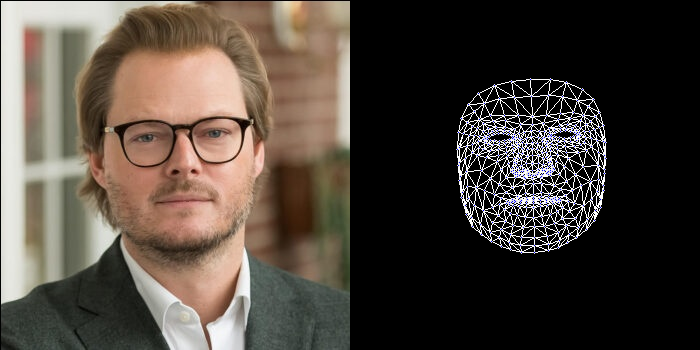

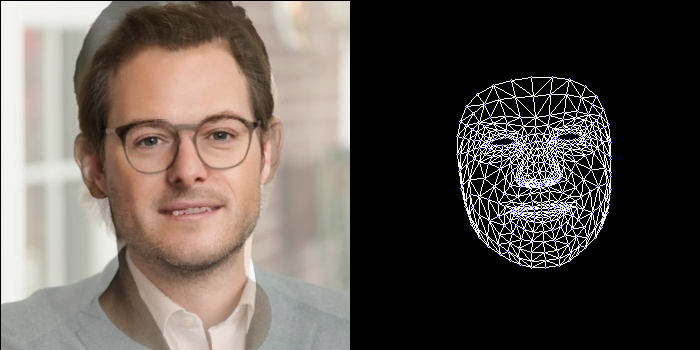

In [ ]:
import cv2
import mediapipe as mp
import os

# Creating a holistic object to access the mesh
mp_holistic = mp.solutions.holistic

# Creating an object to draw the face mesh on the image
mp_drawing = mp.solutions.drawing_utils

# Directory of input and output images
input_dir = "/content/Output_dir/"
# Output_obj = "/content/Output_obj/"

# Looping through each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg') and "frame_" in filename:
        # Reading the input frame
        image = cv2.imread(os.path.join(input_dir, filename))

        # Converting the image to RGB format
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detecting the face mesh on the image
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            results = holistic.process(image_rgb)

        # Creating an empty numpy array for the mask
        mask = np.zeros_like(image)

        # Drawing the face mesh on the mask
        mp_drawing.draw_landmarks(mask, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=0), connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1))

        # Creating a new numpy array for the output image
        output_image = np.zeros((image.shape[0], image.shape[1]*2, image.shape[2]), dtype=np.uint8)

        # Adding the original image to the output image on the left side
        output_image[:, :image.shape[1], :] = image

        # Adding the face mesh to the output image on the right side
        output_image[:, image.shape[1]:, :] = mask

        # Saving the output image in the output directory with the same filename
        cv2.imwrite(os.path.join(output_dir, filename), output_image)
        cv2_imshow(output_image)


# **Saving the mesh coordinates as .obj file**

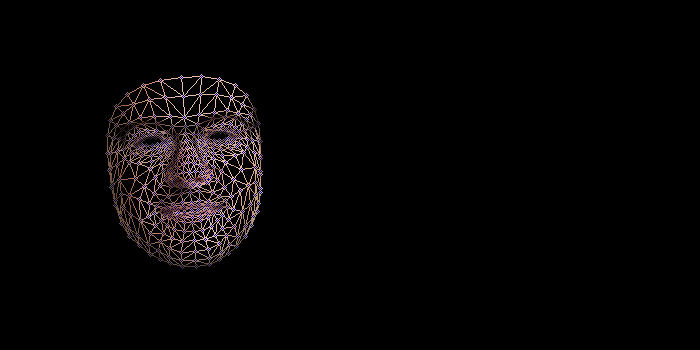

/usr/local/lib/python3.9/dist-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [ ]:
# Extract facemesh and store it as an obj file
# Inputs: face image and canonical_face_model.obj

import os
import cv2
import mediapipe as mp
from pytorch3d.io import load_obj
import numpy as np
from google.colab.patches import cv2_imshow

# Creating a holistic object to access the mesh
mp_holistic = mp.solutions.holistic
 
# Creating an object to draw the face mesh on the image
mp_drawing = mp.solutions.drawing_utils

# Reading the intermediate frame
image = cv2.imread('/content/Output_mesh/frame_1.jpg')

# Converting the image to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detecting the face mesh on the image
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    results = holistic.process(image_rgb)

# Creating an empty numpy array for the mask
mask = np.zeros_like(image)

# Drawing the face mesh on the mask
mp_drawing.draw_landmarks(mask, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1), connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1))

# Creating a new numpy array for the output image
output_image = np.zeros_like(image)

# Applying the mask to the output image
output_image[mask != 0] = image[mask != 0]

cv2_imshow(output_image)

# Load the canonical face mesh
face_obj = os.path.join('canonical_face_model.obj')
# Read the 3D model using load_obj
verts, faces, aux = load_obj(face_obj)
faces_idx = faces.verts_idx

# Extracting the face mesh coordinates from the results
face_mesh_coords = []
for landmark in results.face_landmarks.landmark:
  face_mesh_coords.append((landmark.x, landmark.y, landmark.z))

# Saving the face mesh coordinates and faces as an .obj file
  output_file = "frame_1.obj"
  with open(output_file, "w") as f:
    for coord in face_mesh_coords:
      f.write("v {} {} {}\n".format(coord[0]*image.shape[1], -coord[1]*image.shape[0], -coord[2]*image.shape[1]))
    for i in range(len(faces_idx)):
      f.write("f {} {} {}\n".format(faces_idx[i][0]+1, faces_idx[i][1]+1, faces_idx[i][2]+1))

# **Displaying the rendered 3D face for 1 image**

(-0.5, 511.5, 511.5, -0.5)

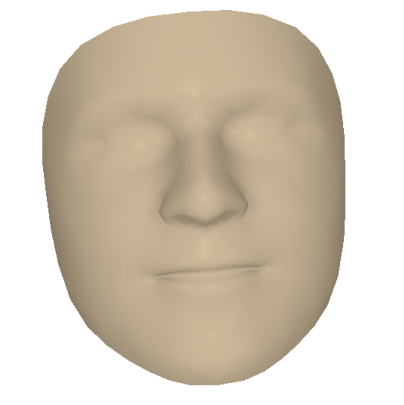

In [ ]:
import os
import numpy as np
import torch
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVOrthographicCameras, look_at_view_transform,
    RasterizationSettings, MeshRenderer, 
    MeshRasterizer, HardPhongShader,
    PointLights,  TexturesVertex
)
import matplotlib.pyplot as plt

device = torch.device("cpu")
# Initialize an OpenGL perspective camera.
R, T = look_at_view_transform(5, 0, 0)
cameras = FoVOrthographicCameras(device=device, 
                                 min_x = -1, max_x = 1,
                                 min_y = -1, max_y = 1,
                                 R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters.
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, specular_color=((0.03, 0.03, 0.03), ), location=[[0.0, 0.0, 300.0]])

# Create a Phong renderer by composing a rasterizer and a shader
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

# Load the face mesh
face_obj = os.path.join('frame_1.obj')
# Read the target 3D model using load_obj
verts, faces, aux = load_obj(face_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# Scale, normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
# verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
# textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Initialize each vertex to be skin color.
verts_rgb = torch.tensor([[1.0, 0.9, 0.75]]).to(device)  # (1, 3)
verts_rgb = verts_rgb.expand(verts.shape[0], -1)  # (V, 3)
textures = TexturesVertex(verts_features=verts_rgb.unsqueeze(0).to(device))


# Construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx], textures=textures)

image = renderer(trg_mesh)
plt.figure(figsize=(5, 5))
plt.imshow(image[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

# **Saving the mesh cooredinates of .obj files saved in a folder through iteration approach**

In [ ]:
import os
import cv2
import mediapipe as mp
from pytorch3d.io import load_obj
import numpy as np
from google.colab.patches import cv2_imshow

# Creating a holistic object to access the mesh
mp_holistic = mp.solutions.holistic

# Creating an object to draw the face mesh on the image
mp_drawing = mp.solutions.drawing_utils

# Load the canonical face mesh
face_obj = os.path.join('canonical_face_model.obj')
# Read the 3D model using load_obj
verts, faces, aux = load_obj(face_obj)
faces_idx = faces.verts_idx

# Define the input and output folders
input_folder = '/content/Output_mesh'
output_folder = '/content/Output_dir'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Get all the frames in the input folder
frames = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]

# Loop over the frames and extract the face mesh
for frame in frames:
    # Reading the frame
    image = cv2.imread(os.path.join(input_folder, frame))

    # Converting the image to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detecting the face mesh on the image
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        results = holistic.process(image_rgb)

    # Creating an empty numpy array for the mask
    mask = np.zeros_like(image)

    # Drawing the face mesh on the mask
    mp_drawing.draw_landmarks(mask, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1), connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1))

    # Creating a new numpy array for the output image
    output_image = np.zeros_like(image)

    # Applying the mask to the output image
    output_image[mask != 0] = image[mask != 0]

    # cv2_imshow(output_image)

    # Extracting the face mesh coordinates from the results
    face_mesh_coords = []
    for landmark in results.face_landmarks.landmark:
        face_mesh_coords.append((landmark.x, landmark.y, landmark.z))

    # Saving the face mesh coordinates and faces as an .obj file
    output_file = os.path.join(output_folder, os.path.splitext(frame)[0] + '.obj')
    with open(output_file, "w") as f:
        for coord in face_mesh_coords:
            f.write("v {} {} {}\n".format(coord[0]*image.shape[1], -coord[1]*image.shape[0], -coord[2]*image.shape[1]))
        for i in range(len(faces_idx)):
            f.write("f {} {} {}\n".format(faces_idx[i][0]+1, faces_idx[i][1]+1, faces_idx[i][2]+1))


# **Display the rendered 3D face for all the present .obj files**

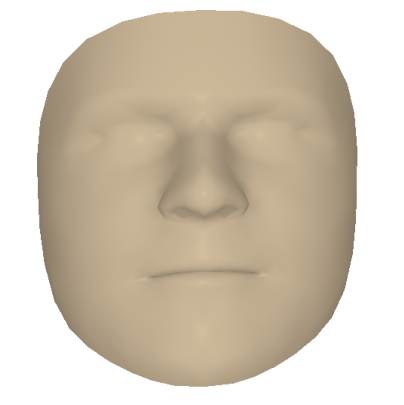

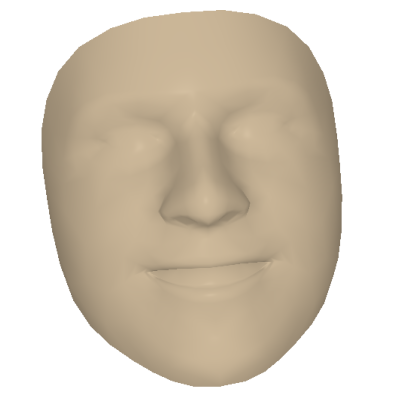

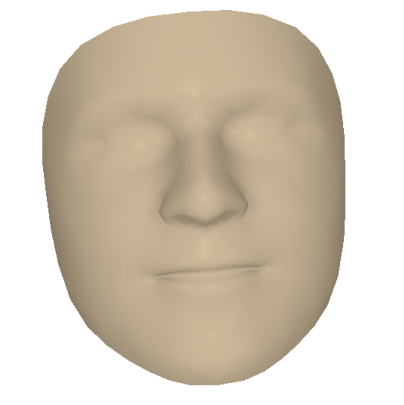

In [ ]:
import os
import numpy as np
import torch
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVOrthographicCameras, look_at_view_transform,
    RasterizationSettings, MeshRenderer, 
    MeshRasterizer, HardPhongShader,
    PointLights,  TexturesVertex
)
import matplotlib.pyplot as plt

device = torch.device("cpu")
# Initialize an OpenGL perspective camera.
R, T = look_at_view_transform(5, 0, 0)
cameras = FoVOrthographicCameras(device=device, 
                                 min_x=-1, max_x=1,
                                 min_y=-1, max_y=1,
                                 R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters.
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, specular_color=((0.03, 0.03, 0.03), ), location=[[0.0, 0.0, 300.0]])

# Create a Phong renderer by composing a rasterizer and a shader
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

# Path to folder containing obj files
folder_path = "/content/Output_dir"

# Loop through all files in the folder with ".obj" extension
for file_name in os.listdir(folder_path):
    if file_name.endswith(".obj"):
        file_path = os.path.join(folder_path, file_name)
        # Load the face mesh
        verts, faces, aux = load_obj(file_path)

        # verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
        # faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
        # For this tutorial, normals and textures are ignored.
        faces_idx = faces.verts_idx.to(device)
        verts = verts.to(device)

        # Scale, normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
        # (scale, center) will be used to bring the predicted mesh to its original center and scale
        # Note that normalizing the target mesh, speeds up the optimization but is not necessary!
        center = verts.mean(0)
        verts = verts - center
        scale = max(verts.abs().max(0)[0])
        verts = verts / scale

        # Initialize each vertex to be skin color.
        verts_rgb = torch.tensor([[1.0, 0.9, 0.75]]).to(device)  # (1, 3)
        verts_rgb = verts_rgb.expand(verts.shape[0], -1)  # (V, 3)
        textures = TexturesVertex(verts_features=verts_rgb.unsqueeze(0).to(device))


        # Construct a Meshes structure for the target mesh
        trg_mesh = Meshes(verts=[verts], faces=[faces_idx], textures=textures)

        image = renderer(trg_mesh)
        image_rgb = image[..., :3]
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb[0, ..., :3].cpu().numpy())
        plt.grid("off")
        plt.axis("off")


# **Displaying the original image, facemesh and rendered 3D face correspondingly**

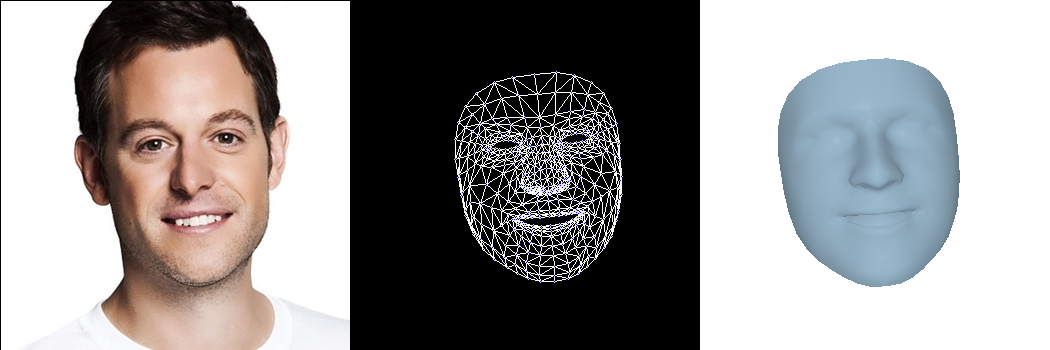

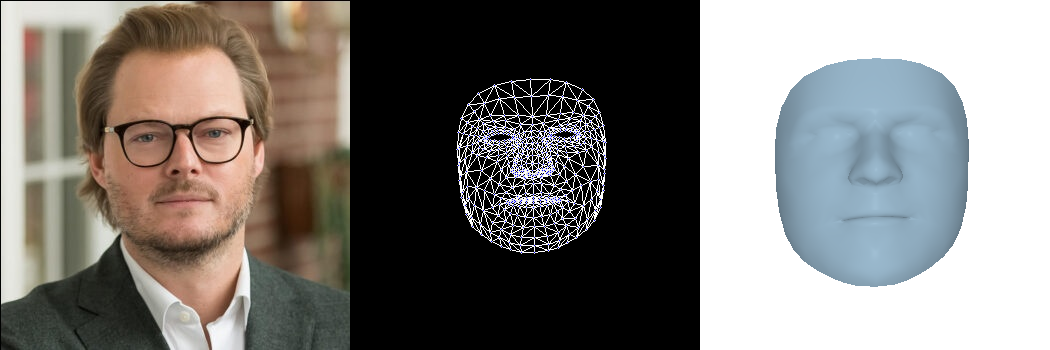

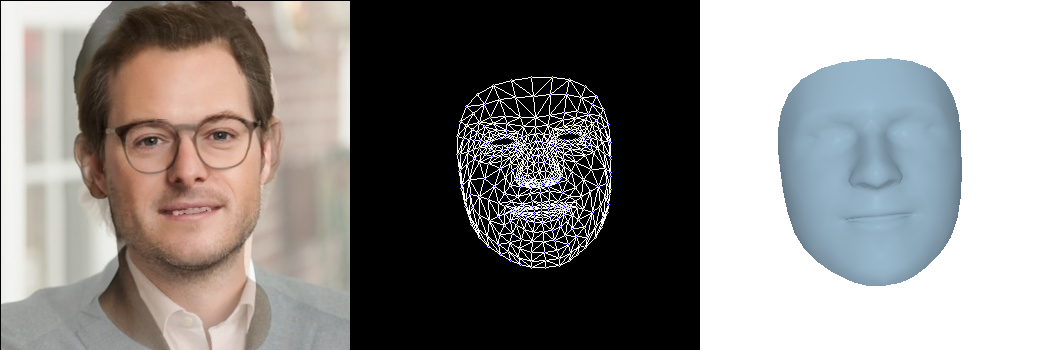

In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np
import torch
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVOrthographicCameras, look_at_view_transform,
    RasterizationSettings, MeshRenderer, 
    MeshRasterizer, HardPhongShader,
    PointLights,  TexturesVertex
)
import matplotlib.pyplot as plt
from pytorch3d.io import load_obj
from google.colab.patches import cv2_imshow
from google.colab import output


# Creating a holistic object to access the mesh
mp_holistic = mp.solutions.holistic

# Creating an object to draw the face mesh on the image
mp_drawing = mp.solutions.drawing_utils

device = torch.device("cpu")
# Initialize an OpenGL perspective camera.
R, T = look_at_view_transform(5, 0, 0)
cameras = FoVOrthographicCameras(device=device, 
                                 min_x=-1.5, max_x=1.5,
                                 min_y=-1.5, max_y=1.5,
                                 R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters.
raster_settings = RasterizationSettings(
    image_size=350,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, specular_color=((0.03, 0.03, 0.03), ), location=[[0.0, 0.0, 300.0]])

# Create a Phong renderer by composing a rasterizer and a shader
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

# Directory of input and output images
input_dir = "/content/Output_dir/"
Output_dir = "/content/Output_obj/"

# Looping through each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg') and "frame_" in filename:
        # Reading the input frame
        image = cv2.imread(os.path.join(input_dir, filename))

        # Converting the image to RGB format
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detecting the face mesh on the image
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            results = holistic.process(image_rgb)

        # Creating an empty numpy array for the mask
        mask = np.zeros_like(image)

        # Drawing the face mesh on the mask
        mp_drawing.draw_landmarks(mask, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=0), connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1))


        obj_filename = filename.replace(".jpg",".obj")
        obj_path = os.path.join(input_dir, obj_filename)

        # Load the face mesh
        verts, faces, aux = load_obj(obj_path)

        faces_idx = faces.verts_idx.to(device)
        verts = verts.to(device)

        center = verts.mean(0)
        verts = verts - center
        scale = max(verts.abs().max(0)[0])
        verts = verts / scale

        # Initialize each vertex to be skin color.
        verts_rgb = torch.tensor([[1.0, 0.9, 0.75]]).to(device)  # (1, 3)
        verts_rgb = verts_rgb.expand(verts.shape[0], -1)  # (V, 3)
        textures = TexturesVertex(verts_features=verts_rgb.unsqueeze(0).to(device))

        # Construct a Meshes structure for the target mesh
        trg_mesh = Meshes(verts=[verts], faces=[faces_idx], textures=textures)

        image_3d = renderer(trg_mesh)
        #Converting
        image_3d = image_3d[0,...,:3].cpu().numpy()*255

        # Creating a new numpy array for the output image
        output_image = np.zeros((image.shape[0], image.shape[1]*3, image.shape[2]), dtype=np.uint8)

        # Adding the original image to the output image on the left side
        output_image[:, :image.shape[1], :] = image

        # Adding the face mesh to the output image on the right side
        output_image[:, image.shape[1]:image.shape[1]*2, :] = mask

        # Adding the third image to the output image on the right side
        output_image[:, image.shape[1]*2:, :] = image_3d

        # Saving the output image in the output directory with the same filename
        cv2.imwrite(os.path.join(Output_dir, filename), output_image)
        cv2_imshow(output_image)

# **Applying skin colour**

In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import TexturesUV
from pytorch3d.renderer import MeshTexturedUV

device = torch.device("cuda:0")  # or "cpu"

# Path to folder containing OBJ files
folder_path = "/content/Output_dir"

# Loop through all files in the folder with ".obj" extension
for file_name in os.listdir(folder_path):
    if file_name.endswith(".obj"):
        file_path = os.path.join(folder_path, file_name)

        # Load the OBJ mesh
        verts, faces, aux = load_obj(file_path)

        # Create a TexturesUV object with the loaded texture image
        texture_file_path = "/content/Output_dir"
        texture_image = torch.io.read_image(texture_file_path).to(device)
        textures = TexturesUV(image=texture_image.unsqueeze(0))

        # Compute UV coordinates for the mesh
        mesh = MeshTexturedUV(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=textures.to(device))
        mesh = mesh.scale_verts(scale_factor=1.0 / max(verts.abs().max(0)[0])).offset_verts((-0.5, -0.5, -0.5))
        mesh.uvs_packed()[0].detach().cpu().numpy()  # This will contain the computed UV coordinates

        # Save the OBJ mesh with computed UV coordinates
        output_file_path = os.path.join(folder_path, file_name.split(".")[0] + "_uv.obj")
        save_obj(output_file_path, verts=[mesh.verts_packed()], faces=[mesh.faces_packed()], uvs=[mesh.textures.verts_uv_packed()])


ImportError: ignored